In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
#dados das eleições de 2006 e 2010
train = pd.read_csv("../data/train.csv")
#dados das eleições de 2014
test = pd.read_csv("../data/test.csv")

# dumy da variável alvo, eleito = 1 e nao_eleito = 0
y = train["situacao"]
y = y.replace(['nao_eleito', 'eleito'], [0, 1])

#removendo variável alvo dos dados de treino
train = train.drop(columns=['situacao'])
#merge treino e teste
data = pd.concat((train, test))
#removendo variáveis irrelevantes
data = data.drop(columns=['sequencial_candidato', 'nome', 'cargo',
                            'quantidade_doacoes', 'total_receita',
                            'quantidade_despesas', 'total_despesa'])

#selecionando atributos numéricos
attr_num = data.dtypes[data.dtypes != "object"].index
#normalizando variáveis numéricas exceto ano
data[attr_num[1:]] = np.log1p(data[attr_num[1:]])

#dummy das variáveis categoricas
data = pd.get_dummies(data)

x = data.loc[data['ano'] != 2014]
test = data.loc[data['ano'] == 2014]

### 1- Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso?

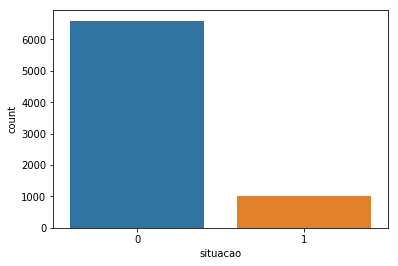

In [3]:
#plotando distribuição da variável alvo
sns.countplot(y)            

As classes estão claramente desbalanceadas, essa diferença pode enviesar a aprendizagem dos modelos. Isso pode ser tratrado por meio de técnicas de `Under-sampling`, neste caso vou utilizar a técnica NearMiss versão 2, que seleciona as amostras da classe majoritária para as quais a distância média até as N-amostras mais distantes da classe minoritária é a menor.

/home/diogo/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


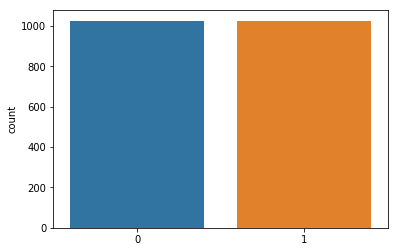

In [4]:
#balanceando as classes
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=2)
x_balanced, y_balanced = nm.fit_resample(x, y)
#plotando distribuição da variável alvo
sns.countplot(y_balanced)

### 2) Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.
A função NearMiss agrupa os dados em suas respectivas classes assim é preciso realizar um shuffle ao selecionar os folds 

In [5]:
#Função para calcular o f1 na validação cruzada
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
def report_cv(model, x, y):
    f1 = cross_val_score(model, x, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=3058))
    return(f1)

#### Logistic Regression

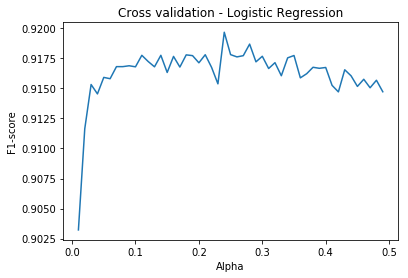

O melhor alpha é 0.24, com F1 = 0.919678902663


In [6]:
from sklearn.linear_model import LogisticRegression
alphas = np.arange(0.01,0.5,0.01).tolist()
cv_logRegression = [report_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=alpha),
                         x_balanced, 
                         y_balanced).mean()
                    for alpha in alphas]
cv_logRegression = pd.Series(cv_logRegression, index = alphas)
#plot do f1 na validação cruzada
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

#### KNN

A melhor quantidade de vizinhos é 23, com F1 = 0.905537365609


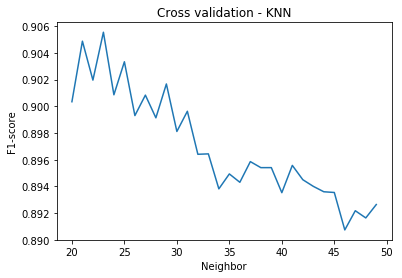

In [7]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(20,50,1).tolist()
cv_knn = [report_cv(KNeighborsClassifier(n_neighbors=neighbor),
               x_balanced,
               y_balanced).mean() 
            for neighbor in neighbors]
cv_knn = pd.Series(cv_knn, index = neighbors)
#plot do f1 na validação cruzada
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Neighbor")
plt.ylabel("F1-score")
print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

#### Árvore de Decisão

A profundidade máxima ideal é 9, com F1 = 0.881885915317


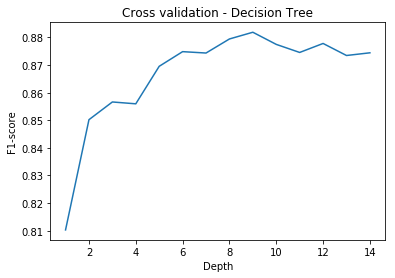

In [8]:
from sklearn.tree import DecisionTreeClassifier
depths = np.arange(1,15,1).tolist()
cv_tree = [report_cv(DecisionTreeClassifier(max_depth = depth),
                x_balanced,
                y_balanced).mean() 
            for depth in depths]
cv_tree = pd.Series(cv_tree, index = depths)
#plot do f1 na validação cruzada
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
print("A profundidade máxima ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

#### Adaboost
Para o parâmetro max_depth utilizei a profundidade ideal encontrada para árvore de decisão.

A quantidade de árvores ideal é 36, com F1 = 0.923681993554


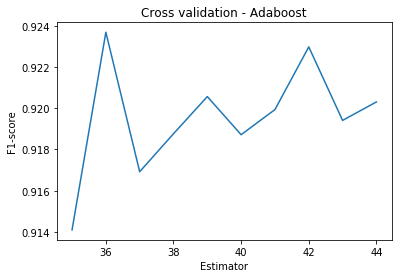

In [9]:
from sklearn.ensemble import AdaBoostClassifier
estimators = np.arange(35,45,1).tolist()
cv_ada =  [report_cv(AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
                x_balanced,
                y_balanced).mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)
#plot do f1 na validação cruzada
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

### 3) Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta.

Função para calcular métricas no treino e validação

In [10]:
from sklearn.model_selection import KFold
def report_train_validation(model,x,y):
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    for train_index, validation_index in kf.split(x_balanced):
        model.fit(x[train_index,:], y[train_index])
        #report train
        predicts_train = model.predict(x[train_index,:])
        report_train = metrics.classification_report(y[train_index], predicts_train, output_dict=True)["macro avg"]
        #report validation
        predicts_validation = model.predict(x[validation_index,:])
        report_validation = metrics.classification_report(y[validation_index], predicts_validation, 
                                                         output_dict=True)["macro avg"]
        #print metrics
        print("Precision = train:{0} - validation:{1}".format(report_train["precision"], report_validation["precision"]))
        print("Recall = train:{0} - validation:{1}".format(report_train["recall"], report_validation["recall"]))
        print("AUC-Precision&Recall = train:{0} - validation:{1}".format(report_train["f1-score"], report_validation["f1-score"]))
        return 

Reportando métricas no treino e na validação

In [11]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegression.idxmax())
print("Logistic Regression")
report_train_validation(log_reg, x_balanced, y_balanced)

Logistic Regression
Precision = train:0.922704014928 - validation:0.929434051622
Recall = train:0.922622389776 - validation:0.929454390452
AUC-Precision&Recall = train:0.922605291704 - validation:0.929438718424


In [12]:
knn = KNeighborsClassifier(n_neighbors=cv_knn.idxmax())
print("KNN")
report_train_validation(knn, x_balanced, y_balanced)

KNN
Precision = train:0.918490912347 - validation:0.894068404688
Recall = train:0.91657754249 - validation:0.890167661267
AUC-Precision&Recall = train:0.916423819641 - validation:0.890196334535


In [13]:
tree = DecisionTreeClassifier(max_depth = cv_tree.idxmax())
print("Decision Tree")
report_train_validation(tree, x_balanced, y_balanced)

Decision Tree
Precision = train:0.983085299617 - validation:0.902242524917
Recall = train:0.982848453694 - validation:0.902643831061
AUC-Precision&Recall = train:0.982930330427 - validation:0.902421652422


In [14]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=cv_ada.idxmax())
print("AdaBoost")
report_train_validation(ada, x_balanced, y_balanced)

AdaBoost
Precision = train:1.0 - validation:0.917548647366
Recall = train:1.0 - validation:0.916954976303
AUC-Precision&Recall = train:1.0 - validation:0.917164603784


As métricas no treino são melhores do que na validação para todos os casos, conforme esperado. Os modelos tem melhor ajuste aos folds que foram usados no seus treinamentos, por isso métricas extraidas dos dados de treino não expressam a capacidade de generalização do modelo. 

### 4) Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?

In [26]:
pd.DataFrame(tree.feature_importances_).max()

0    0.498921
dtype: float64

### 5) Envie seus melhores modelos à competição do Kaggle.

In [30]:
def test_model(model):
    model.fit(x_balanced, y_balanced)
    print(metrics.classification_report(y, model.predict(x), output_dict=True)["macro avg"]["f1-score"])

### Testando Outros Modelos

#### Random Forest

Novamente, para o parâmetro max_depth utilizei a profundidade ideal encontrada para árvore de decisão

A quantidade de árvores ideal é 171, com F1 = 0.91185789342


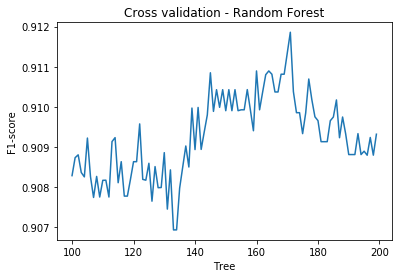

In [27]:
from sklearn.ensemble import RandomForestClassifier
trees = np.arange(100,200,1).tolist()
cv_random_forest = [report_cv(RandomForestClassifier(n_estimators=tree, max_depth=cv_tree.idxmax(), random_state=0),
                         x_balanced,
                         y_balanced).mean() 
                    for tree in trees]
cv_random_forest = pd.Series(cv_random_forest, index = trees)
#plot do AUC-Precision&Recall na validação cruzada
cv_random_forest.plot(title = "Cross validation - Random Forest")
plt.xlabel("Tree")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_random_forest.idxmax(), cv_random_forest.max()))

In [ ]:
random_forest = RandomForestClassifier(n_estimators=cv_random_forest.idxmax(), max_depth=cv_tree.idxmax(), 
                                       random_state=10)
test_model(random_forest)

#### Ridge

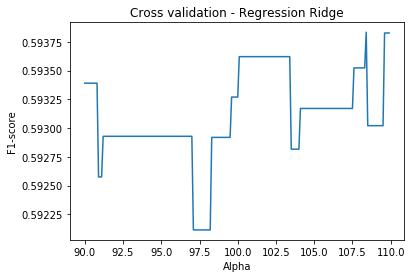

O melhor alpha é 108.4, com F1 = 0.593832970849


In [28]:
from sklearn.linear_model import RidgeClassifier
alphas = np.arange(90,110,0.1).tolist()
cv_ridge = [report_cv(RidgeClassifier(alpha = alpha),
                          x, 
                          y).mean()
                    for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
#plot do AUC-Precision&Recall na validação cruzada
cv_ridge.plot(title = "Cross validation - Regression Ridge")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_ridge.idxmax(), cv_ridge.max()))

In [31]:
ridge = RidgeClassifier(alpha=cv_ridge.idxmax())
test_model(ridge)

0.797239600678


### Regressão Logistíca L1

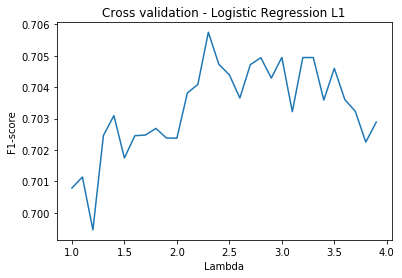

O melhor alpha é 2.3, com F1 = 0.705745247949


In [33]:
from sklearn.linear_model import LogisticRegression
lambdas = np.arange(1,4,0.1).tolist()
cv_logRegression = [report_cv(LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, C=lbd, random_state=1), 
                          x, y).mean()
                    for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)
#plot do AUC-Precision&Recall na validação cruzada
cv_logRegression.plot(title = "Cross validation - Logistic Regression L1")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

In [34]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, 
                           C=cv_logRegression.idxmax(), random_state=1)
test_model(lasso)

0.784993449791


### Submission

In [37]:
submission = pd.read_csv("../data/sample_submission.csv")
m = KNeighborsClassifier(n_neighbors=cv_knn.idxmax())
m.fit(x, y)
predicts_submission = pd.DataFrame(m.predict(test))
predicts_submission = predicts_submission.replace([0, 1],['nao_eleito', 'eleito'])
submission["Predicted"] = predicts_submission
submission.to_csv("../data/sample_submission.csv", index=False)